In [100]:
#import

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

In [101]:
# init Node class

class Node:
    def __init__(self, feature_index, threshold, left, right, value):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  #if leaf  

In [102]:
# init DecisionTree class

class DecisionTree:
    def __init__(self,max_depth, min_samples_split):
        self.max_depth = max_depth
        self.min_samples_split= min_samples_split
        self.root = None
        self.feature_importances = np.zeros(30)

    def get_feature_importances(self):
        return self.feature_importances

    def fit(self, x, y):
        self.root = self.build_tree(x, y, depth=0)

    def predict(self, x):
        predictions = x.apply(lambda row: self.traverse_tree(row, self.root), axis = 1)
        # x.apply(..., axis = 1): loops over all rows
        # lambda row: defines a small anonymous function, instead of def, basically means for each row recieved
        return predictions.values # returns numpy array of predictions

    def build_tree(self, x, y, depth):
        unique_labels, counts = np.unique(y, return_counts=True)
        majority_class = unique_labels[np.argmax(counts)] # returns index of class with most count

        if depth >= self.max_depth or len(y) < self.min_samples_split or len(y.unique()) == 1: #if max depth exceeded or
            return Node(None, None, None, None, majority_class)                                # if samples less than min samples or if pure node
        
        best_gain, feature_index, threshold = self.find_best_split(x, y)

        if best_gain < 1e-9:
            return Node(None, None, None, None, majority_class)

        else:
            self.feature_importances[feature_index] += best_gain
            feature_column =x.iloc[:, feature_index]

            filter_left = feature_column <= threshold
            filter_right = feature_column > threshold

            x_left, y_left = x[filter_left], y[filter_left]
            x_right, y_right = x[filter_right], y[filter_right]

            left_child = self.build_tree(x_left, y_left, depth + 1)
            right_child = self.build_tree(x_right, y_right, depth + 1)

        return Node(feature_index, threshold, left_child, right_child, None)
    
    def traverse_tree(self, x_row, node):
        if node.value is not None:
            return node.value
        
        feature_value = x_row.iloc[node.feature_index]

        if feature_value <= node.threshold:
            return self.traverse_tree(x_row, node.left)
        else:
            return self.traverse_tree(x_row, node.right)

    def calculate_entropy(self, y):
        entropy = 0
        totSamples = len(y)
        # get unique class labels and their counts
        # unique returns the sorted unique elements
        # return_counts returns the number of times each unique element appears
        class_labels, counts = np.unique(y, return_counts=True)
        
        for i in counts:
            p_k = i / totSamples
            entropy += (-p_k * math.log2(p_k))

        return entropy
    
    def find_best_split(self,x, y):
        max_info_gain = -math.inf
        best_feature = None
        best_threshold = None
        totSamples = len(y)

        entropy_Y = self.calculate_entropy(y)

        for candidate_feature in range(x.shape[1]): # x.shape[1] is the total number of features

            feature_data = x.iloc[:, candidate_feature] # returns values present in column feature
            sorted_unique_values = np.sort(feature_data.unique()) # unique values

            for i in range(len(sorted_unique_values) - 1):

                candidate_threshold = (sorted_unique_values[i] + sorted_unique_values[i + 1]) / 2

                filter_left = feature_data <= candidate_threshold # boolean mask, True on label if true, False if not
                filter_right = feature_data > candidate_threshold

                y_left = y[filter_left] # uses mask to select only values with True
                y_right = y[filter_right]

                samples_left = len(y_left)
                samples_right = len(y_right)

                #avoids splits where one child node is empty
                if samples_left == 0 or samples_right == 0:
                    continue

                entropy_left = self.calculate_entropy(y_left)
                entropy_right = self.calculate_entropy(y_right)

                entropy_YgivenX = (samples_left / totSamples) * entropy_left + (samples_right / totSamples) * entropy_right

                info_gain = entropy_Y - entropy_YgivenX

                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_feature = candidate_feature
                    best_threshold = candidate_threshold

        return max_info_gain, best_feature, best_threshold

In [103]:
# accuracy helper function

def calculate_accuracy(y_predictions, y_actual):
    return (y_predictions == y_actual).mean()

In [104]:
#loads dataset

cancer = load_breast_cancer() 
# tot samples = 569
# 212 malignant, 357 benign
# 30 features/columns

x = pd.DataFrame(cancer.data, columns = cancer.feature_names)
y = pd.Series(cancer.target)

print("Target class distribution:")
print(y.value_counts())

Target class distribution:
1    357
0    212
Name: count, dtype: int64


In [105]:
# split dataset too 70% training, 15% testing, 15% validation

x_train, x_temp, y_train, y_temp = train_test_split(
    x, y,
    test_size = 0.3,
    random_state = 42,
    stratify = y
)

x_test, x_validation, y_test, y_validation = train_test_split(
    x_temp, y_temp,
    test_size = 0.5,
    random_state = 42,
    stratify = y_temp
)

print(f"Training set size: {x_train.shape[0]} samples ({round(x_train.shape[0]/x.shape[0]*100)}%)")
print(f"Validation set size: {x_validation.shape[0]} samples ({round(x_validation.shape[0]/x.shape[0]*100)}%)")
print(f"Test set size: {x_test.shape[0]} samples ({round(x_test.shape[0]/x.shape[0]*100)}%)")

Training set size: 398 samples (70%)
Validation set size: 86 samples (15%)
Test set size: 85 samples (15%)


In [106]:
# hyperparameter tuning (finding best max depth and min samples split)

best_validation_accuracy = -1
best_hyperparameters = {}

print("Validation accuracies over all combinations:\n")
for max_depth in [2, 4, 6, 8, 10]:
    for min_samples_split in [2, 5, 10]:
        
        model = DecisionTree(max_depth, min_samples_split)
        model.fit(x_train, y_train)

        y_validation_predictions = model.predict(x_validation)

        validation_accuracy = calculate_accuracy(y_validation_predictions, y_validation)

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_hyperparameters = {
                'max depth': max_depth,
                'min samples split': min_samples_split
            }
        print(f" Depth = {max_depth}, Samples = {min_samples_split} : {validation_accuracy}")

print(f"\nBest validation accuracy:\n {best_validation_accuracy}")
print(f"Best hyperparameters:\n {best_hyperparameters}")

Validation accuracies over all combinations:

 Depth = 2, Samples = 2 : 0.8837209302325582
 Depth = 2, Samples = 5 : 0.8837209302325582
 Depth = 2, Samples = 10 : 0.8837209302325582
 Depth = 4, Samples = 2 : 0.9302325581395349
 Depth = 4, Samples = 5 : 0.9302325581395349
 Depth = 4, Samples = 10 : 0.9302325581395349
 Depth = 6, Samples = 2 : 0.9302325581395349
 Depth = 6, Samples = 5 : 0.9302325581395349
 Depth = 6, Samples = 10 : 0.9302325581395349
 Depth = 8, Samples = 2 : 0.9186046511627907
 Depth = 8, Samples = 5 : 0.9302325581395349
 Depth = 8, Samples = 10 : 0.9302325581395349
 Depth = 10, Samples = 2 : 0.9186046511627907
 Depth = 10, Samples = 5 : 0.9302325581395349
 Depth = 10, Samples = 10 : 0.9302325581395349

Best validation accuracy:
 0.9302325581395349
Best hyperparameters:
 {'max depth': 4, 'min samples split': 2}


In [107]:
# retraining on train + validation & evaluation on test

x_train_validation = pd.concat([x_train, x_validation])
y_train_validation = pd.concat([y_train, y_validation])

final_model = DecisionTree(best_hyperparameters["max depth"], best_hyperparameters["min samples split"])
final_model.fit(x_train_validation, y_train_validation)

y_test_predictions = final_model.predict(x_test)
test_accuracy = calculate_accuracy(y_test_predictions, y_test)

print(f"Test set accuracy:\n {test_accuracy}")

Test set accuracy:
 0.9411764705882353


In [108]:
# analyzing training and validation accuracies when max depth is variable and min samples is fixed (10)

analysis_data = []

for max_depth in [2, 4, 6, 8, 10]:
    model = DecisionTree(max_depth, 10)
    model.fit(x_train, y_train)

    y_train_predictions = model.predict(x_train)
    train_accuracy = calculate_accuracy(y_train_predictions, y_train)

    y_validation_predictions = model.predict(x_validation)
    validation_accuracy = calculate_accuracy(y_validation_predictions, y_validation)

    analysis_data.append({
        'Max depth': max_depth,
        'Training accuracy': train_accuracy,
        'Validation accuracy': validation_accuracy
    })

for data in analysis_data:
    print(f"Depth: {data['Max depth']}, Train Acc: {data['Training accuracy']}, Validation Acc: {data['Validation accuracy']}")

Depth: 2, Train Acc: 0.9522613065326633, Validation Acc: 0.8837209302325582
Depth: 4, Train Acc: 0.9899497487437185, Validation Acc: 0.9302325581395349
Depth: 6, Train Acc: 0.992462311557789, Validation Acc: 0.9302325581395349
Depth: 8, Train Acc: 0.992462311557789, Validation Acc: 0.9302325581395349
Depth: 10, Train Acc: 0.992462311557789, Validation Acc: 0.9302325581395349


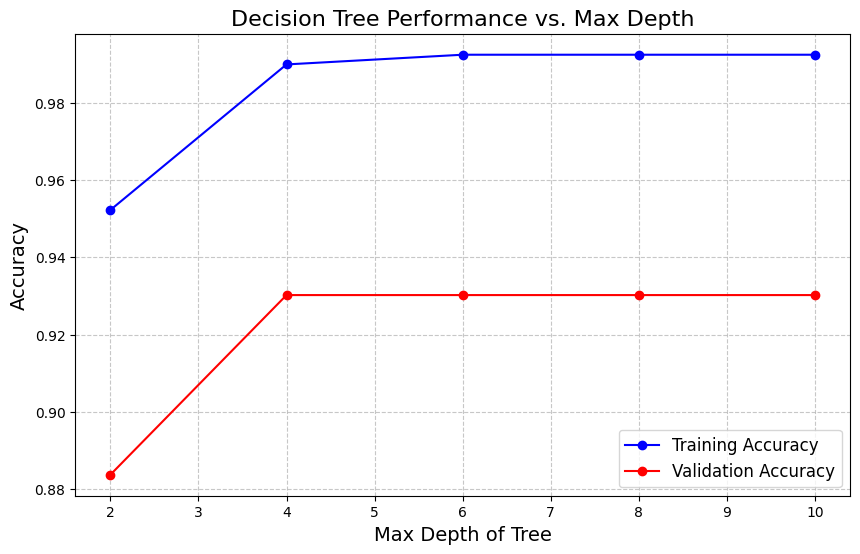

In [109]:
# plot max depth vs training accuracy and validation accuracy

df_analysis = pd.DataFrame(analysis_data)

plt.figure(figsize=(10, 6))

plt.plot(
    df_analysis['Max depth'],
    df_analysis['Training accuracy'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Training Accuracy'
)

plt.plot(
    df_analysis['Max depth'],
    df_analysis['Validation accuracy'],
    marker='o',
    linestyle='-',
    color='red',
    label='Validation Accuracy'
)

plt.title('Decision Tree Performance vs. Max Depth', fontsize=16)
plt.xlabel('Max Depth of Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


Confusion Matrix:
[[31  1]
 [ 4 49]]


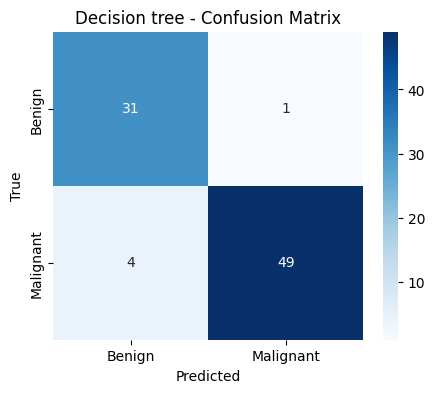

In [110]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_predictions)

print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision tree - Confusion Matrix')
plt.show()

In [111]:
print("Performance Metrics")

final_accuracy = accuracy_score(y_test, y_test_predictions)
print(f" Accuracy: {final_accuracy:.4f}")

precision_class1 = precision_score(y_test, y_test_predictions, pos_label=1)
recall_class1 = recall_score(y_test, y_test_predictions, pos_label=1)
f1_class1 = f1_score(y_test, y_test_predictions, pos_label=1)

print("\nMetrics for Class 1 (Positive/Malignant)")
print(f" Precision: {precision_class1:.4f}")
print(f" Recall: {recall_class1:.4f}")
print(f" F1-score: {f1_class1:.4f}")

precision_class0 = precision_score(y_test, y_test_predictions, pos_label=0)
recall_class0 = recall_score(y_test, y_test_predictions, pos_label=0)
f1_class0 = f1_score(y_test, y_test_predictions, pos_label=0)

print("\nMetrics for Class 0 (Negative/Benign)")
print(f" Precision: {precision_class0:.4f}")
print(f" Recall: {recall_class0:.4f}")
print(f" F1-score: {f1_class0:.4f}")

Performance Metrics
 Accuracy: 0.9412

Metrics for Class 1 (Positive/Malignant)
 Precision: 0.9800
 Recall: 0.9245
 F1-score: 0.9515

Metrics for Class 0 (Negative/Benign)
 Precision: 0.8857
 Recall: 0.9688
 F1-score: 0.9254


In [113]:
# ranking features by their information gain contribution

feature_scores = final_model.get_feature_importances()
feature_names = x_train_validation.columns.tolist() 

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_scores
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df)


Feature Importance Ranking:
                    Feature  Importance
21            worst texture    0.881038
0               mean radius    0.811278
22          worst perimeter    0.560538
6            mean concavity    0.394209
4           mean smoothness    0.224120
27     worst concave points    0.194016
26          worst concavity    0.122279
13               area error    0.064777
8             mean symmetry    0.000000
7       mean concave points    0.000000
5          mean compactness    0.000000
3                 mean area    0.000000
1              mean texture    0.000000
2            mean perimeter    0.000000
12          perimeter error    0.000000
11            texture error    0.000000
10             radius error    0.000000
9    mean fractal dimension    0.000000
17     concave points error    0.000000
14         smoothness error    0.000000
16          concavity error    0.000000
15        compactness error    0.000000
20             worst radius    0.000000
19  fractal